Демонстрация простой вариационной модели и ее прунинга.

**Disclaimer**: могут быть ошибки, кроме того, функии могут быть написаны неоптимально.

In [151]:
import torch as t 
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms

In [152]:
device = 'cpu' # cuda or cpu

In [153]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 5 #количество эпох
lamb = [0, 0.1, 0.5, 1, 5, 10, 100]
# lam = 1.0 # коэффициент перед дивергенцией
hidden_num = 10 # количество нейронов на скрытом слое
t.manual_seed(42) # задаем значение генератора случайных чисел для повторяемости экспериментов

In [154]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [155]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2

In [156]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self):
        k = 0
        for l in self:
            k+=l.KLD()
        return k

In [157]:
def train_batches(net, loss_fn, optimizer, i):
    for id, (x,y) in enumerate(train_loader):  
            id+=1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()            
            optimizer.zero_grad()   
            out[i] = net(x)
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
            out_loss[i] = loss_fn(out[i], y)* len(train_data)         
            kld[i] =  net.KLD() * lam        
            loss[i] = (out_loss[i]+kld[i])       
            if id %100 == 0:           
                print ("Number of net:",i, loss[i].data, out_loss[i].data, kld[i].data)            
            loss[i].backward()       
            clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
            optimizer.step()

In [158]:
def statistic(net, loss_fn, i):
    net.eval()  
    kld[i] =  net.KLD() 
    loss[i] = kld[i]
    for x,y in test_loader:
         if device == 'cuda':
            x = x.cuda()
            y = y.cuda()          
    out[i] = net(x)   
    out_loss[i] = loss_fn(out[i], y)* len(train_data)/len(test_data)   
    #  print(out_loss[i])
    # print(loss[i])
    loss[i] += out_loss[i]
    net.train()
    print (loss[i])
    return loss[i]


    

In [159]:
# рассмотрим для примера сеть, состояющую из двух слоев
# второй слой - softmax. По сути для обучения задавать активацию явно не нужно, она забита в nn.CrossEntropyLoss
def init_nets():
    for i in range(3):
        nets.append(VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)))
        optimizer_nets.append(optim.Adam(nets[i].parameters()))
    loss_fn_nets = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss(), nn.CrossEntropyLoss()] 
    loss_graf=[[],[],[]]
    out = [None, None, None]
    out_loss = [None, None, None]
    kld = [None, None, None]
    loss = [None, None, None]

def train_nets():
    for epoch in range(epoch_num):             
        for i,net in enumerate(nets):
            train_batches(net,loss_fn_nets[i], optimizer_nets[i],i)
        print ('end of epoch: ', epoch)   
        for i,net in enumerate(nets):
            print("Number of net:",i)        
            loss_graf[i].append(statistic(net, loss_fn_nets[i], i))

        

In [160]:
#print(loss_graf)
def graph_loss_func():
    for i,net in enumerate(nets): 
        plt.plot(loss_graf[i])
    plt.ylabel('Loss function')
    plt.xlabel('Number of epoche')
    plt.show()
#print(out_loss)

#graph_loss_func()

In [161]:
def test_acc(): # точность классификации
    acc = []
    for i,net in enumerate(nets):
        correct = 0
        net.eval()
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()     
            out[i] = net(x)    
            correct += out[i].argmax(1).eq(y).sum().cpu().numpy()
        acc.append(correct / len(test_data))
    print(sum(acc)/len(acc))   
    return(sum(acc)/len(acc))
#test_acc()

In [162]:
# коэффициенты информативности, см. статью practical variational inference
# попробуем удалять параметры первого слоя по этому коэффициенту

def init_coeff():
    for i,net in enumerate(nets): 
        mu.append(net[0].mean) 
        sigma.append(t.exp(2*net[0].log_sigma))
        prune_coef.append((mu[i]**2/sigma[i]).cpu().detach().numpy())
    print(prune_coef)

#init_coeff()    


In [163]:
# будем удалять по 10% от модели и смотреть качество
def delete_10():
    flag = 0
    print(prune_coef)
    for j in range(10):
        for i,net in enumerate(nets): 
            if (flag == 0):
                sorted_coefs = np.sort(prune_coef[i].flatten())
                flag = 1
            ids = (prune_coef[i] <= sorted_coefs[round(j/10*len(sorted_coefs))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc())
        #(test_acc()) #среднее по всем nets
    
#delete_10()    
    

In [164]:
def graph():
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.plot(proc, acc_delete)
    plt.ylabel('Accuracy')
    plt.xlabel('Procent')

# graph()   


In [165]:
# проверяем, что фокусов тут нет, удаляем оставшиеся 10%\
def delete_last10():
    flag = 0
    for j in range(10):
        for i,net in enumerate(nets): 
            if (flag == 0):
                sorted_coefs = np.sort(prune_coef[i].flatten())
                flag = 1
            ids = (prune_coef[i] <= sorted_coefs[round((0.9+j/100)*len(sorted_coefs))]) 
            net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
            print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        (test_acc())
    for i,net in enumerate(nets):
        net[0].mean.data*=0
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    
#delete_last10()    

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


Number of net: 0 tensor(125475.1406) tensor(125475.1406) tensor(0.)
Number of net: 0 tensor(109208.2266) tensor(109208.2266) tensor(0.)
Number of net: 1 tensor(115026.8047) tensor(115026.8047) tensor(0.)
Number of net: 1 tensor(77652.9375) tensor(77652.9375) tensor(0.)
Number of net: 2 tensor(79912.8203) tensor(79912.8203) tensor(0.)
Number of net: 2 tensor(49200.6680) tensor(49200.6680) tensor(0.)
end of epoch:  0
Number of net: 0
tensor(19965.5781, grad_fn=<AddBackward0>)
Number of net: 1
tensor(19975.0859, grad_fn=<AddBackward0>)
Number of net: 2
tensor(19976.5039, grad_fn=<AddBackward0>)
Number of net: 0 tensor(71032.9375) tensor(71032.9375) tensor(0.)
Number of net: 0 tensor(65900.6094) tensor(65900.6094) tensor(0.)
Number of net: 1 tensor(63762.8672) tensor(63762.8672) tensor(0.)
Number of net: 1 tensor(62077.2812) tensor(62077.2812) tensor(0.)
Number of net: 2 tensor(39888.9883) tensor(39888.9883) tensor(0.)
Number of net: 2 tensor(38848.3984) tensor(38848.3984) tensor(0.)
end o

0.8154
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.2466)
nonzero params:  tensor(0.2716)
0.8103666666666666
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.1443)
nonzero params:  tensor(0.1723)
0.7122666666666667
Number of net: 0 tensor(82009.9609) tensor(80021.0391) tensor(1988.9199)
Number of net: 0 tensor(66788.3906) tensor(64805.3086) tensor(1983.0801)
Number of net: 1 tensor(121627.0391) tensor(119641.6562) tensor(1985.3854)
Number of net: 1 tensor(101942.3594) tensor(99966.8438) tensor(1975.5140)
Number of net: 2 tensor(112365.3672) tensor(110376.7734) tensor(1988.5911)
Number of net: 2 tensor(96911.7031) tensor(94930.4688) tensor(1981.2366)
end of epoch:  0
Number of net: 0
tensor(19810.5703, grad_fn=<AddBackward0>)
Number of net: 1
tensor(19720.6348, grad_fn=<AddBackward0>)
Number of net: 2
tensor(19786.3086, grad_fn=<AddBackward0>)
Number of net: 0 tensor(50613.1406) tensor(48639.5664) tensor(1973.5729)
Number of net: 0 tensor(52721.9453) tensor(50756.7

0.8828666666666667
nonzero params:  tensor(0.4999)
nonzero params:  tensor(0.4662)
nonzero params:  tensor(0.4829)
0.8801333333333332
nonzero params:  tensor(0.3999)
nonzero params:  tensor(0.3686)
nonzero params:  tensor(0.3888)
0.8643333333333333
nonzero params:  tensor(0.2999)
nonzero params:  tensor(0.2699)
nonzero params:  tensor(0.2820)
0.8475666666666667
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.1818)
nonzero params:  tensor(0.1916)
0.8197666666666666
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.0927)
nonzero params:  tensor(0.1011)
0.6751666666666667
Number of net: 0 tensor(94562.7266) tensor(84650.3438) tensor(9912.3828)
Number of net: 0 tensor(72583.6250) tensor(62676.3594) tensor(9907.2686)
Number of net: 1 tensor(95670.0703) tensor(85830.9141) tensor(9839.1543)
Number of net: 1 tensor(72797.8750) tensor(63099.2539) tensor(9698.6211)
Number of net: 2 tensor(91242.3516) tensor(81398.3594) tensor(9843.9902)
Number of net: 2 tensor(85125.8203) tenso

0.8747666666666666
nonzero params:  tensor(0.4999)
nonzero params:  tensor(0.4158)
nonzero params:  tensor(0.3689)
0.8630666666666666
nonzero params:  tensor(0.3999)
nonzero params:  tensor(0.3376)
nonzero params:  tensor(0.3011)
0.8523999999999999
nonzero params:  tensor(0.2999)
nonzero params:  tensor(0.2654)
nonzero params:  tensor(0.2307)
0.8442666666666666
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.1898)
nonzero params:  tensor(0.1593)
0.8102999999999999
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.0969)
nonzero params:  tensor(0.0761)
0.5900666666666667
Number of net: 0 tensor(92733.0859) tensor(73026.3047) tensor(19706.7793)
Number of net: 0 tensor(82896.8438) tensor(63357.9766) tensor(19538.8691)
Number of net: 1 tensor(113672.2969) tensor(94000.2969) tensor(19672.0020)
Number of net: 1 tensor(94906.9453) tensor(75467.4375) tensor(19439.5098)
Number of net: 2 tensor(108685.8047) tensor(88902.7109) tensor(19783.0918)
Number of net: 2 tensor(79050.4453

0.8872666666666668
nonzero params:  tensor(0.7999)
nonzero params:  tensor(0.8185)
nonzero params:  tensor(0.8636)
0.8838666666666667
nonzero params:  tensor(0.6999)
nonzero params:  tensor(0.7033)
nonzero params:  tensor(0.7686)
0.8784000000000001
nonzero params:  tensor(0.5999)
nonzero params:  tensor(0.5949)
nonzero params:  tensor(0.6684)
0.8725
nonzero params:  tensor(0.4999)
nonzero params:  tensor(0.4997)
nonzero params:  tensor(0.5677)
0.8553000000000001
nonzero params:  tensor(0.3999)
nonzero params:  tensor(0.3894)
nonzero params:  tensor(0.4529)
0.8166333333333333
nonzero params:  tensor(0.2999)
nonzero params:  tensor(0.2950)
nonzero params:  tensor(0.3390)
0.8010999999999999
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.1978)
nonzero params:  tensor(0.2249)
0.7883999999999999
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.1050)
nonzero params:  tensor(0.1115)
0.6669666666666666
Number of net: 0 tensor(185762.3750) tensor(87826.9062) tensor(97935.4766

0.8873666666666667
nonzero params:  tensor(0.8999)
nonzero params:  tensor(0.9182)
nonzero params:  tensor(0.9094)
0.8876666666666666
nonzero params:  tensor(0.7999)
nonzero params:  tensor(0.8268)
nonzero params:  tensor(0.7960)
0.8855666666666666
nonzero params:  tensor(0.6999)
nonzero params:  tensor(0.7380)
nonzero params:  tensor(0.7060)
0.8807666666666667
nonzero params:  tensor(0.5999)
nonzero params:  tensor(0.6501)
nonzero params:  tensor(0.6273)
0.8718666666666667
nonzero params:  tensor(0.4999)
nonzero params:  tensor(0.5505)
nonzero params:  tensor(0.5284)
0.8608333333333333
nonzero params:  tensor(0.3999)
nonzero params:  tensor(0.4499)
nonzero params:  tensor(0.4305)
0.8485999999999999
nonzero params:  tensor(0.2999)
nonzero params:  tensor(0.3333)
nonzero params:  tensor(0.3241)
0.8172333333333333
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.2191)
nonzero params:  tensor(0.2082)
0.7719999999999999
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.100

0.8927
nonzero params:  tensor(0.8999)
nonzero params:  tensor(0.8866)
nonzero params:  tensor(0.9247)
0.8926333333333334
nonzero params:  tensor(0.7999)
nonzero params:  tensor(0.7973)
nonzero params:  tensor(0.8398)
0.8933666666666668
nonzero params:  tensor(0.6999)
nonzero params:  tensor(0.7085)
nonzero params:  tensor(0.7543)
0.8934666666666667
nonzero params:  tensor(0.5999)
nonzero params:  tensor(0.6133)
nonzero params:  tensor(0.6691)
0.8888666666666666
nonzero params:  tensor(0.4999)
nonzero params:  tensor(0.5066)
nonzero params:  tensor(0.5665)
0.8792999999999999
nonzero params:  tensor(0.3999)
nonzero params:  tensor(0.4003)
nonzero params:  tensor(0.4489)
0.8722666666666666
nonzero params:  tensor(0.2999)
nonzero params:  tensor(0.2901)
nonzero params:  tensor(0.3244)
0.8558333333333333
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.1814)
nonzero params:  tensor(0.2017)
0.8133666666666667
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.1005)
nonzero p

0.8774000000000001
nonzero params:  tensor(0.8999)
nonzero params:  tensor(0.9425)
nonzero params:  tensor(0.9446)
0.876
nonzero params:  tensor(0.7999)
nonzero params:  tensor(0.8515)
nonzero params:  tensor(0.8593)
0.8740333333333333
nonzero params:  tensor(0.6999)
nonzero params:  tensor(0.7452)
nonzero params:  tensor(0.7724)
0.8717666666666668
nonzero params:  tensor(0.5999)
nonzero params:  tensor(0.6489)
nonzero params:  tensor(0.6587)
0.8599
nonzero params:  tensor(0.4999)
nonzero params:  tensor(0.5511)
nonzero params:  tensor(0.5457)
0.8496666666666667
nonzero params:  tensor(0.3999)
nonzero params:  tensor(0.4411)
nonzero params:  tensor(0.4261)
0.8282333333333334
nonzero params:  tensor(0.2999)
nonzero params:  tensor(0.3337)
nonzero params:  tensor(0.3231)
0.8153
nonzero params:  tensor(0.1999)
nonzero params:  tensor(0.2136)
nonzero params:  tensor(0.2059)
0.7950333333333334
nonzero params:  tensor(0.0999)
nonzero params:  tensor(0.0996)
nonzero params:  tensor(0.1106)
0.

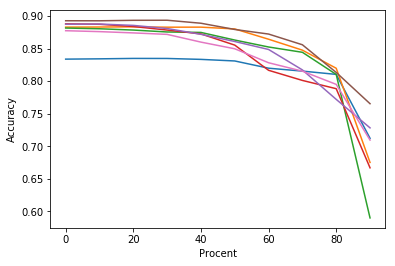

In [168]:
for k,lam in enumerate(lamb):
    acc_delete = [] 
    nets = []
    optimizer_nets = []
    mu = []
    sigma = []
    prune_coef = []
    init_nets()
    train_nets()
    #graph_loss_func()
    init_coeff()
    delete_10()
    graph()
plt.show()
    

In [134]:

init_coeff()
delete_10()



[array([[2.6936382e-01, 1.0640321e+00, 5.7452932e-02, ..., 6.7602813e-01,
        1.3789254e-02, 1.5713231e-01],
       [7.1855374e-02, 7.0443940e-01, 2.6623064e-03, ..., 6.2368882e-01,
        8.2746518e-01, 1.3216255e+00],
       [6.9820946e-01, 1.3170063e-01, 2.1695089e-01, ..., 7.4240476e-02,
        8.9227721e-02, 2.1992934e+00],
       ...,
       [4.7082552e-01, 1.8184975e+00, 3.4246358e-01, ..., 1.4228056e-01,
        7.5836319e-01, 1.6449578e-01],
       [5.4279274e-01, 3.0362649e+00, 1.3113405e+00, ..., 1.3760267e+00,
        1.7842611e-02, 4.1094947e-01],
       [2.0830789e-01, 3.2988248e+00, 2.7313893e+00, ..., 1.9576693e-02,
        6.1738282e-02, 1.8082861e+00]], dtype=float32), array([[3.6328045e-01, 1.6444086e+00, 2.5399778e+00, ..., 8.5829598e-01,
        8.1680202e-01, 1.4564714e-01],
       [3.6823338e-01, 9.7499579e-02, 3.0316523e-01, ..., 1.7589324e+00,
        3.7940958e-01, 9.2497449e-03],
       [3.6019866e+00, 7.3937815e-01, 9.9103969e-01, ..., 2.2290082e+00,
 